## Get bounding boxes from parking lot images using YOLOv8n

In [1]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')  # load a pretrained YOLOv8n model

In [5]:
# Process all images from the "UFPR05" location, save bounding box centers, and plot them
import matplotlib.pyplot as plt
import os
#Specify the image directory
image_dir = "aligned_images/ufpr05_template_matching/"
image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
print(f"Number of images: {len(os.listdir(image_dir))}")

Number of images: 1924


### Get YOLO results for all images

In [36]:
import cv2
import os

def process_images_with_yolo(image_files, model, save_annotated=False, output_dir="annotated_images", plot_centers=False):
    """
    Process images with YOLO, extract bounding box information, and optionally save annotated images.

    Args:
        image_files (list): List of image file paths to process.
        model (YOLO): YOLO model instance.
        save_annotated (bool): Whether to save annotated images. Default is False.
        output_dir (str): Directory to save annotated images if save_annotated is True. Default is "annotated_images".

    Returns:
        dict: Dictionary containing bounding box information for each image.
    """
    # Initialize a dictionary to store bounding box information
    bounding_box_infos = {}

    # Create output directory if saving annotated images
    if save_annotated:
        os.makedirs(output_dir, exist_ok=True)

    # Iterate through each image in the directory
    frame = -1
    for image_path in image_files:
        frame += 1

        # Run the image through the YOLO model
        results = model(image_path, verbose=False)

        # Access the first result
        result = results[0]

        # Extract bounding box information
        boxes = result.boxes  # Get the bounding boxes
        if boxes is not None:
            image_info = []  # List to store bounding box info for this image
            img = cv2.imread(image_path)  # Read the image for annotation

            for box in boxes:
                # Extract bounding box details
                center_x, center_y, width, height = box.xywh.tolist()[0]  # xywh format
                confidence = box.conf.tolist()[0]  # Confidence score
                class_id = int(box.cls.tolist()[0])  # Class ID
                label = result.names[class_id]  # Class label

                # Append the details as a dictionary
                image_info.append({
                    'center_x': center_x,
                    'center_y': center_y,
                    'width': width,
                    'height': height,
                    'confidence': confidence,
                    'label': label,
                    'frame': frame
                })

                # Annotate the image if saving
                if save_annotated:
                    top_left = (int(center_x - width / 2), int(center_y - height / 2))
                    bottom_right = (int(center_x + width / 2), int(center_y + height / 2))
                    cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 2)  # Draw bounding box
                    cv2.putText(img, f"{label} {confidence:.2f}", (top_left[0], top_left[1] - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
                # Plot the center of the bounding box
                if plot_centers:
                    center = (int(center_x), int(center_y))
                    cv2.circle(img, center, radius=3, color=(0, 0, 255), thickness=-1)  # Draw center point
            # Add the bounding box info for this image to the dictionary
            bounding_box_infos[os.path.basename(image_path)] = image_info

            # Save the annotated image
            if save_annotated:
                output_path = os.path.join(output_dir, os.path.basename(image_path))
                cv2.imwrite(output_path, img)

    return bounding_box_infos

bounding_box_infos = process_images_with_yolo(image_files, model)

In [ ]:
#Save bounding box information to a file
import json
with open('bounding_box_infos.json', 'w') as f:
    json.dump(bounding_box_infos, f, indent=4)

In [92]:
#Load from JSON file
with open('bounding_box_infos.json', 'r') as f:
    bounding_box_infos = json.load(f)

## Get summary information

In [8]:
from collections import Counter

# Initialize a Counter to store class counts
class_counts = Counter()

# Iterate through bounding_box_infos to count classes
for image_name, boxes in bounding_box_infos.items():
    for box in boxes:
        class_label = box['label']
        class_counts[class_label] += 1

# Print the detected classes and their counts
print("Detected Classes and Counts:")
for class_label, count in class_counts.items():
    print(f"{class_label}: {count}")

Detected Classes and Counts:
car: 58070
person: 266
truck: 403
bus: 501
cell phone: 183
traffic light: 8
airplane: 24
boat: 8
potted plant: 11


### Define visualization functions

In [218]:
# Function to plot bounding box centers for a specific class with a minimum confidence score
def plot_class_scatter(class_name, min_confidence=0.0):
    # Extract centers for the specified class with confidence >= min_confidence
    class_centers = [
        (box['center_x'], box['center_y'])
        for boxes in bounding_box_infos.values()
        for box in boxes
        if box['label'] == class_name and box['confidence'] >= min_confidence
    ]

    # Check if there are any instances of the class
    if class_centers:
        x_coords, y_coords = zip(*class_centers)
        plt.figure(figsize=(8, 6))
        plt.scatter(x_coords, y_coords, alpha=0.7, s=5, edgecolors='k', label=class_name)
        plt.title(f"Scatter Plot of '{class_name}' Bounding Box Centers\n(Min Confidence: {min_confidence})")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"No instances of class '{class_name}' found with confidence >= {min_confidence}.")

In [221]:
# Function to overlay bounding box centers on a parking lot image
def plot_class_scatter_overlay(image_path, class_name, min_confidence=0.0):
    # Extract centers for the specified class with confidence >= min_confidence
    class_centers = [
        (box['center_x'], box['center_y'])
        for boxes in bounding_box_infos.values()
        for box in boxes
        if box['label'] == class_name and box['confidence'] >= min_confidence
    ]

    # Check if there are any instances of the class
    if class_centers:
        x_coords, y_coords = zip(*class_centers)

        # Load the parking lot image
        img = plt.imread(image_path)

        # Plot the image as the background
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.scatter(x_coords, y_coords, alpha=0.7, s=20, edgecolors='k', label=class_name, color='red')
        plt.title(f"Overlay of '{class_name}' Bounding Box Centers (Min Confidence: {min_confidence})")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        plt.axis('off')  # Turn off axes for better visualization
        plt.show()
    else:
        print(f"No instances of class '{class_name}' found with confidence >= {min_confidence}.")

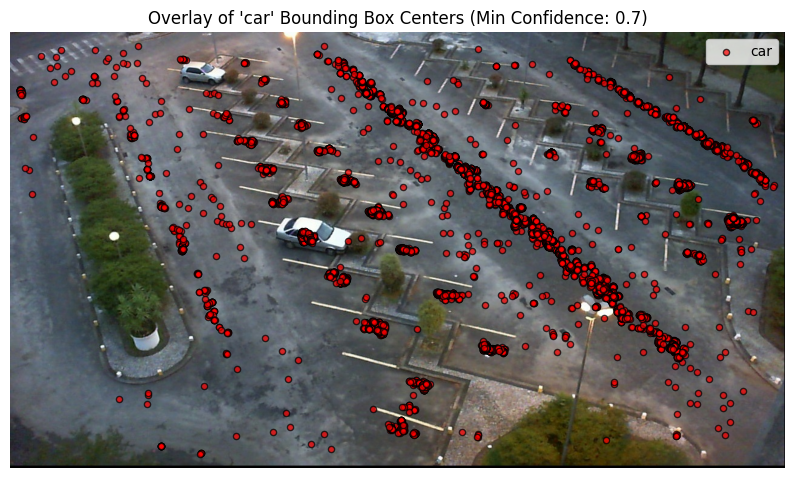

In [222]:

background_image_path = "aligned_images/ufpr05_template_matching/2013-02-22_06_05_00.jpg"
# Overlay the scatter plot for the class "car" with a minimum confidence of 0.7
plot_class_scatter_overlay(background_image_path, "car", min_confidence=0.7)

## Filtering and heuristics

Apply some logic to filter out points that appear for one frame only, to remove cars-in-transit.  Parked cars should remain stationary (i.e. bounding box center moving only within small margin) for more than one image.

More meangful results are possible with 

In [ ]:
#Functions to process YOLO data to filter out points

import math
from collections import defaultdict


# Function to calculate Euclidean distance between two points
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# Function to process the JSON data with min_persistence and organize by frame
def process_json_data(data, 
                      label, 
                      confidence_threshold, 
                      radius, 
                      min_persistence,
                      target_date=None):
    # Step 1: Filter data by label and confidence threshold, and organize by frame
    points_by_frame = defaultdict(list)
    for image, detections in data.items():
        #image is of format "2013-02-22_06_15_00.jpg"
        date = image.split('_')[0]
        if target_date and date != target_date:
            continue #only use target date if specified
        #Extract the date
        for detection in detections:
            # Extract only relevant fields and filter by label and confidence
            if detection["label"] == label and detection["confidence"] >= confidence_threshold:
                points_by_frame[detection["frame"]].append((detection["center_x"], detection["center_y"]))
    
    # Convert to a sorted list of frames
    max_frame = max(points_by_frame.keys(), default=-1)  # Handle empty data gracefully
    organized_data = [points_by_frame[frame] for frame in range(max_frame + 1)]
        
    # Step 2: Compare points across frames with persistence
    matching_points = set()  # Use a set to avoid duplicates
    for i, current_points in enumerate(organized_data):
        for point in current_points:
            persistence_count = 1  # Start with the current frame
            cluster = {point}  # Track the cluster of matching points

            # Check consecutive frames forward
            for j in range(1, min_persistence):
                if i + j < len(organized_data):  # Ensure we don't go out of bounds
                    found_match = False
                    for next_point in organized_data[i + j]:
                        if euclidean_distance(point, next_point) <= radius:
                            cluster.add(next_point)
                            found_match = True
                            break
                    if found_match:
                        persistence_count += 1
                    else:
                        break  # Stop checking if no match is found

            # Check consecutive frames backward
            for j in range(1, min_persistence):
                if i - j >= 0:  # Ensure we don't go out of bounds
                    found_match = False
                    for prev_point in organized_data[i - j]:
                        if euclidean_distance(point, prev_point) <= radius:
                            cluster.add(prev_point)
                            found_match = True
                            break
                    if found_match:
                        persistence_count += 1
                    else:
                        break  # Stop checking if no match is found

            # If the point persists for the required number of frames, add the cluster
            if persistence_count >= min_persistence:
                matching_points.update(cluster)

    # Step 3: Return the matching points as a list
    return list(matching_points), points_by_frame

In [205]:
#Overlay matching points on parking lot image
def plot_matching_points_overlay(image_path, 
                                 matching_points, 
                                 radius, 
                                 persistence, 
                                 label, 
                                 confidence_threshold,
                                 save_image_path=False,
                                 show_image=True,
                                 date=None,
                                 cluster_properties=None):
    # Load the parking lot image
    img = plt.imread(image_path)

    # Plot the image as the background
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    
    if matching_points:
        x_coords, y_coords = zip(*matching_points)
        plt.scatter(x_coords, y_coords, alpha=0.7, s=10, edgecolors='k', label='Matching Points', color='red')
        
    # Plot cluster centers and radii if cluster_properties is provided
    if cluster_properties:
        for cluster_id, properties in cluster_properties.items():
            center = properties["center"]
            cluster_radius = properties["radius"]
            
            # Plot the cluster center
            #plt.scatter(center[0], center[1], c="blue", marker="x", s=100, label=f"Cluster {cluster_id} Center")
            
            # Plot the cluster radius as a circle
            circle = plt.Circle(center, cluster_radius*2, color="blue", fill=False, linestyle="--", linewidth=1.5)
            plt.gca().add_artist(circle)
    
    if date:
        if cluster_properties:
            plt.title(f"Clusters (N={len(cluster_properties)}) for \"{label}\" label on {date}\nRadius: {radius}, Persistence: {persistence}, Confidence Threshold: {confidence_threshold})")
        else:
            plt.title(f"Points for \"{label}\" label on {date}\nRadius: {radius}, Persistence: {persistence}, Confidence Threshold: {confidence_threshold})")
    else:
        plt.title(f"Points for \"{label}\" label\nRadius: {radius}, Persistence: {persistence}, Confidence Threshold: {confidence_threshold})")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    #plt.legend()
    plt.axis('off')  # Turn off axes for better visualization
    if save_image_path:
        plt.savefig(save_image_path)
    if show_image:
        pass
        #plt.show()
    else:
        plt.close()


### Visualize filtered images

In [154]:
label = "car"
confidence_threshold = 0.5
radius = 2
persistence = 5

matching_points, points_by_frame = process_json_data(bounding_box_infos, label, confidence_threshold, radius, min_persistence=persistence)
print("Matching Points:", len(matching_points))

Matching Points: 19715


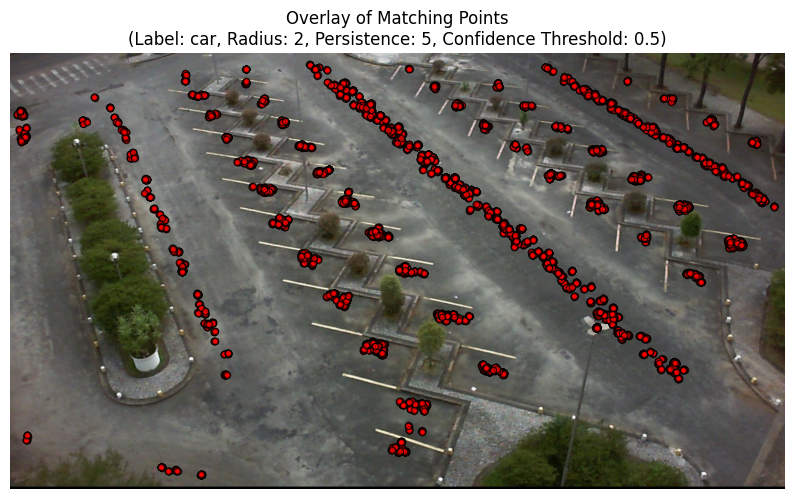

In [ ]:
background_image_path = "aligned_images/ufpr05_template_matching/2013-02-24_09_05_03.jpg"
# Overlay the matching points on the parking lot image
plot_matching_points_overlay(background_image_path, 
                             matching_points, 
                             radius, 
                             persistence, 
                             label, 
                             confidence_threshold)

### Clusters by date

The total aggregated results above show neatly-clustered points in places clearly marked as parking spots, but less order in places without clear markings.  On different days, the pattern of parked cars in unmarked areas may begin in a slightly different place, blurring the resulting clusters.

Consider the results one day at a time, which will have more clear patterns, and consider the day-by-day statistics to determine the total number of parking spots 

In [223]:
#Function to count clusters using DBSCAN
from sklearn.cluster import DBSCAN
import numpy as np

def count_clusters(points, eps=2.0, min_samples=3):
    """
    Count the number of clusters in a set of points using DBSCAN.

    Args:
        points (list of tuples): List of (x, y) coordinates.
        eps (float): Maximum distance between two points to be considered in the same cluster.
        min_samples (int): Minimum number of points required to form a cluster.

    Returns:
        int: Number of clusters found.
        list: Cluster labels for each point (-1 indicates noise).
    """
    if not points:
        #print("No points provided.")
        return 0, []

    # Convert points to a NumPy array
    points_array = np.array(points)

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(points_array)

    # Count the number of clusters (excluding noise)
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    return num_clusters, labels

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def compute_cluster_properties(points, labels):
    """
    Compute the center and radius of each cluster.

    Args:
        points (list of tuples): List of (x, y) coordinates.
        labels (list): Cluster labels for each point.

    Returns:
        dict: A dictionary with cluster properties:
              {cluster_id: {"center": (x, y), "radius": r}}
    """
    cluster_properties = {}
    points_array = np.array(points)

    # Get unique cluster labels (excluding noise, which is -1)
    unique_labels = set(labels)
    if -1 in unique_labels:
        unique_labels.remove(-1)

    for cluster_id in unique_labels:
        # Get points belonging to the current cluster
        cluster_points = points_array[np.array(labels) == cluster_id]

        # Compute the center as the mean of all points in the cluster
        center = cluster_points.mean(axis=0)

        # Compute the radius as the maximum distance from the center
        distances = np.linalg.norm(cluster_points - center, axis=1)
        radius = distances.max()

        # Store the cluster properties
        cluster_properties[cluster_id] = {"center": tuple(center), "radius": radius}

    return cluster_properties

In [159]:
#Get dates from aligned_images/ufpr05_template_matching/ 
image_dir = "aligned_images/ufpr05_template_matching/"
dates = []
for file in os.listdir(image_dir):
    if file.endswith('.jpg'):
        date = file.split('_')[0]
        dates.append(date)
dates = list(set(dates))  # Remove duplicates
print("Available Dates:", len(dates))

Available Dates: 31


In [225]:
#Iterate through dates and process data
background_image_path = "aligned_images/ufpr05_template_matching/2013-02-24_09_05_03.jpg"

all_clusters = {}
num_clusters_by_date = {}
for date in dates:
    matching_points, points_by_frame = process_json_data(bounding_box_infos, 
                                                         label = 'car', 
                                                         confidence_threshold = 0.6, 
                                                         radius = 2, 
                                                         min_persistence = 3, 
                                                         target_date=date)
    
    #count clusters
    epsilon = 5.0  # Maximum distance between points in a cluster
    min_samples = 2  # Minimum points to form a cluster

    num_clusters, labels = count_clusters(matching_points, eps=epsilon, min_samples=min_samples)
    cluster_properties = compute_cluster_properties(matching_points, labels)
    #print(f"Date: {date}, cluster_properties: {cluster_properties}")
    
    plot_matching_points_overlay(background_image_path, 
                                 matching_points, 
                                 radius, 
                                 persistence, 
                                 label, 
                                 confidence_threshold,
                                 save_image_path=False, #f"points_by_date/clustered_{date}.png",
                                 show_image=False,
                                 date=date,
                                 cluster_properties=cluster_properties)
    num_clusters_by_date[date] = len(cluster_properties)
    all_clusters[date] = cluster_properties

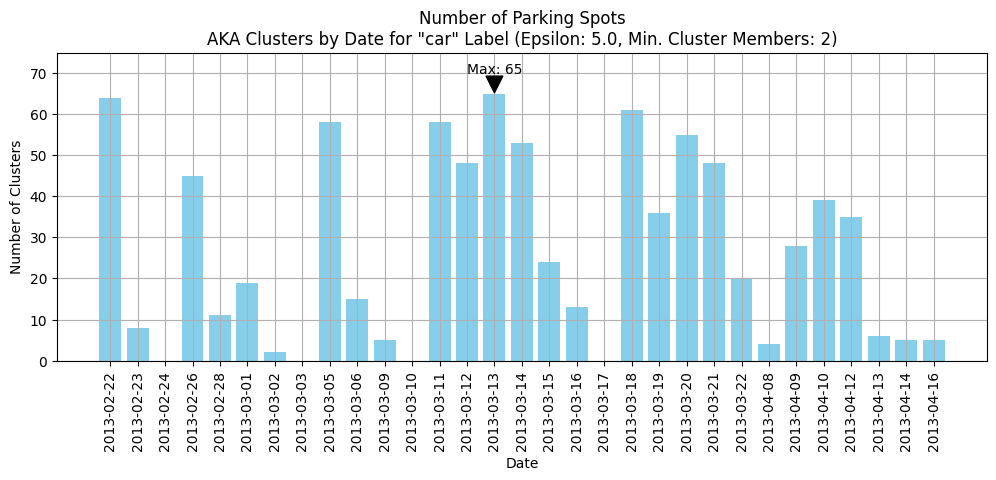

In [ ]:
#Plot the number of clusters (aka parking spots) by date
dates_sorted = sorted(num_clusters_by_date.keys())
cluster_counts = [num_clusters_by_date[date] for date in dates_sorted]
plt.figure(figsize=(12, 4))
plt.bar(dates_sorted, cluster_counts, color='skyblue')
plt.xticks(rotation=90)
#Annotate the maximum bar
max_clusters = max(cluster_counts)
max_date = dates_sorted[cluster_counts.index(max_clusters)]
plt.annotate(
    f'Max: {max_clusters}', 
    xy=(max_date, max_clusters), 
    xytext=(max_date, max_clusters + 5),  # Offset the text higher above the arrow
    arrowprops=dict(facecolor='black', shrink=0.05),
    ha='center'
)
#y axis limit
plt.ylim(0, max_clusters + 10)
plt.title(f"Number of Parking Spots\nAKA Clusters by Date for \"{label}\" Label (Epsilon: {epsilon}, Min. Cluster Members: {min_samples})")
plt.xlabel("Date")
plt.ylabel("Number of Clusters")
plt.grid(True)
plt.show()

### Potted plant investigation

In [230]:
label = "potted plant"
confidence_threshold = 0.4
radius = 2
persistence = 1

matching_points, _ = process_json_data(bounding_box_infos, label, confidence_threshold, radius, min_persistence=persistence)
print("Matching Points:", len(matching_points))

Matching Points: 3


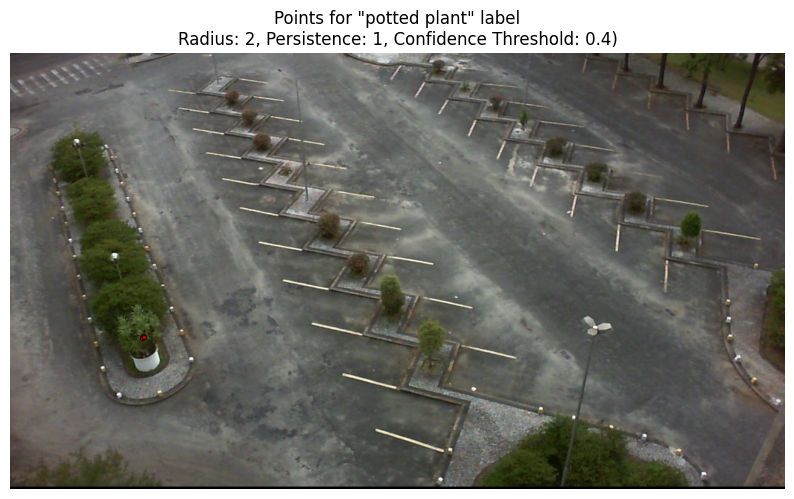

In [231]:
background_image_path = "aligned_images/ufpr05_template_matching/2013-02-24_09_05_03.jpg"
# Overlay the matching points on the parking lot image
plot_matching_points_overlay(background_image_path, matching_points, radius, persistence, label, confidence_threshold)